# Deep Learning Project 1: DeepPaint

This section defines the necessary classes to handle the dataset (download, uncompress, split, etc.)

In [ ]:
from PIL import Image, ImageCms
import os, os.path
import torch
from enum import Enum
import numpy as np
from skimage.color import rgb2lab, rgb2gray, lab2rgb, xyz2rgb
from torchvision import datasets, transforms
import torchvision.models as models
import random
from sklearn.model_selection import train_test_split
import glob

class GrayscaleImageFolder(datasets.ImageFolder):
  '''Custom images folder, which converts images to grayscale before loading'''
  def __getitem__(self, index):
    path, target = self.imgs[index]
    img = self.loader(path)
    img_l = None
    img_ab = None
    if self.transform is not None:
      img_original = self.transform(img)
      img_original = np.asarray(img_original)
      img_lab = rgb2lab(img_original)
      img_lab = (img_lab + 128) / 255
      img_ab = img_lab[:, :, 1:3]
      img_ab = torch.from_numpy(img_ab.transpose((2, 0, 1))).float()
      img_l = img_lab[:, :, 0:1]
      img_l = torch.from_numpy(img_l.transpose((2, 0, 1))).float()

    if self.target_transform is not None:
      print("TARGET_TRANSFORM IS NOT NONE")
      target = self.target_transform(target)
    return img_l, img_ab, target

class Dataset:
  def __init__(self, tSetSize, vSetSize):
    self.__tSetSize = tSetSize / 100
    self.__vSetSize = vSetSize / 100

  trainingSetPath = "/content/VOCdevkitReduced/train"
  validationSetPath = "/content/VOCdevkitReduced/validation"

  #################
  # private members
  #################
  __datasetUrl = "host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar"
  __datasetTarball = "/content/VOCtrainval_11-May-2012.tar"
  __datasetPath = "/content/VOCdevkit/"
  __datasetReduced = "/content/VOCdevkitReduced"
  __datasetImages = []
  __tSetSize = 0.0
  __vSetSize = 0.0

  #################
  # private methods
  #################
  def __downloadDataset(self):
    # download database
    if os.path.exists(self.__datasetTarball):
      print("Dataset tarball already downloaded!")
    else:
      url = self.__datasetUrl
      !wget $url
      print("Dataset tarball was properly downloaded!")

    # untar the dabase
    if os.path.exists(self.__datasetPath):
      print("Dataset tarball already uncompressed!")
    elif os.path.exists(self.__datasetTarball):
      tarball = self.__datasetTarball
      !tar -xf $tarball
      print("Dataset tarball was properly uncompressed!")

  def __getImagesListFromPath(self, datasetPath, imageType):
    images = []
    validImagesExt = [".jpg",".png"]

    if not os.path.exists(datasetPath):
      print("Error: dataset does not exist!")
      return images

    imagesFound = None
    if imageType == "JPG":
      imagesFound = glob.glob(datasetPath + "/**/*.jpg", recursive = True)
    elif imageType == "PNG":
      imagesFound = glob.glob(datasetPath + "/**/*.png", recursive = True)
    elif imageType == "JPG_AND_PNG":
      imagesFound = glob.glob(datasetPath + "/**/*.png", recursive = True) + glob.glob(datasetPath + "/**/*.jpg", recursive = True)

    if imagesFound == None:
      print("Error: no images found!")
      return images

    for file in imagesFound:
      ext = os.path.splitext(file)[1]
      if ext.lower() in validImagesExt:
        images.append(file)

    return images


  def __saveImagesIn(self, images, rootPath):
    for img in images:
      if not os.path.exists(img):
        print("Dataset image does not exist!")
        return
      picture = Image.open(img)
      picture.save(rootPath + "/" + os.path.basename(img))

  def __splitDataset(self, datasetImages):
    if not (len(datasetImages) > 0):
      print("Error: dataset images do not exist!")
      return

    classtSetPath = self.trainingSetPath + "/class"
    classvSetPath = self.validationSetPath + "/class"

    if os.path.exists(classtSetPath) and os.path.exists(classvSetPath):
      print("Dataset is already split!")
      return

    splitTsetSize = int(round(self.__tSetSize * len(datasetImages)))
    splitVsetSize = int(round(self.__vSetSize * len(datasetImages)))
    #random.shuffle(datasetImages) #remove random
    train, validation = train_test_split(datasetImages, train_size = splitTsetSize, test_size = splitVsetSize, random_state=42)
    dirs = [classtSetPath, classvSetPath]
    for dir in dirs:
      !mkdir -p $dir

    if not os.path.exists(classtSetPath) or not os.path.exists(classvSetPath):
      print("New dataset dirs not created!")
      return

    self.__saveImagesIn(train, classtSetPath)
    self.__saveImagesIn(validation, classvSetPath)
    print("Dataset was properly split!")


  ################
  # public members
  ################
  def cleanup(self, filesToRemove, all):
    if all:
      filesToRemove = self.__datasetPath + " " + self.__datasetReduced + " " + self.__datasetTarball
    !rm -rf $filesToRemove

  def setupDataset(self):
    self.__downloadDataset()
    self.__dataseImages = self.__getImagesListFromPath(self.__datasetPath, "JPG")
    self.__splitDataset(self.__dataseImages)

This section defines the necessary classes to train the model

In [ ]:
import os, time, shutil, argparse
from functools import partial
import pickle
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import lab2rgb, xyz2rgb, lab2xyz
from skimage import io
!pip install torchmetrics
!pip install scipy
!pip install torch-fidelity
!pip install pytorch-lightning --upgrade
!pip install lightning-bolts
from pytorch_lightning.metrics.functional import ssim
from torchmetrics import PSNR
from torchmetrics import SSIM
import scipy
import torch_fidelity
from torchmetrics import FID

class AverageMeter(object):
  '''An easy way to compute and store both average and current values'''
  def __init__(self):
    self.reset()

  def reset(self):
    self.val = 0
    self.avg = 0
    self.sum = 0
    self.count = 0

  def update(self, val, n=1):
    self.val = val
    self.sum += val * n
    self.count += n
    self.avg = self.sum / self.count

class Worker():
  def __init__(self, pintFreq, useGPU):
    self.print_freq = pintFreq
    self.use_gpu = useGPU
  
  print_freq = 10
  use_gpu = False

  __outputGray = "/content/VOCdevkitOutputs/gray/"
  __outputColor = "/content/VOCdevkitOutputs/color/"
  __outputRoot = "/content/VOCdevkitOutputs/"

  def __getRgbImage(self, l_input, ab_input):
    rgbImage = None
    ab_input = ab_input.cpu()
    if ab_input is not None:
      labImage = torch.cat((l_input, ab_input), dim = 0).numpy()
      labImage = (labImage * 255) - 128
      labImage = labImage.transpose((1, 2, 0))
      rgbImage = lab2rgb(labImage.astype(np.float64))
    return rgbImage

  def __saveColorImage(self, rgbImage, save_path, save_name):
    plt.clf() # clear matplotlib plot
    if save_path is not None and save_name is not None and rgbImage is not None:
        plt.imsave(arr=rgbImage, fname='{}{}'.format(save_path['colorized'], save_name))

  def createOutputDirs(self):
    dirs = [self.__outputGray, self.__outputColor]
    for dir in dirs:
      !mkdir -p $dir

  def cleanup(self):
    dir = self.__outputRoot
    !rm -rf $dir

  def train(self, train_loader, model, criterion, optimizer, epoch, prevLoss):
    '''Train model on data in train_loader for a single epoch'''
    print('Starting training epoch {}'.format(epoch))

    # Prepare value counters and timers
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()

    # Switch model to train mode
    model.train()

    # Train for single eopch
    end = time.time()

    for i, (input_gray, input_ab, target) in enumerate(train_loader):
      # Use GPU if available
      input_gray_variable = Variable(input_gray).cuda() if self.use_gpu else Variable(input_gray)
      input_ab_variable = Variable(input_ab).cuda() if self.use_gpu else Variable(input_ab)
      target_variable = Variable(target).cuda() if self.use_gpu else Variable(target)

      # Record time to load data (above)
      data_time.update(time.time() - end)

      # Run forward pass
      output_ab = model(input_gray_variable) # throw away class predictions
      loss, output_ab = criterion(output_ab, input_ab_variable, prevLoss)
      prevLoss = loss.data

      # Record loss and measure accuracy
      # original generates an error, it is solved here https://stackoverflow.com/questions/56483122/indexerror-invalid-index-of-a-0-dim-tensor-use-tensor-item-to-convert-a-0-di
      #losses.update(loss.data[0], input_gray.size(0))
      losses.update(loss.data, input_gray.size(0))

      # Compute gradient and optimize
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # Record time to do forward and backward passes
      batch_time.update(time.time() - end)
      end = time.time()

      # Print model accuracy -- in the code below, val refers to value, not validation
      if i % self.print_freq == 0:
              print('Epoch: [{0}][{1}/{2}]\t'
                    'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                    'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
                    'Loss {loss.val:.4f} ({loss.avg:.4f})\t'.format(
                      epoch, i, len(train_loader), batch_time=batch_time,
                     data_time=data_time, loss=losses)) 
    print('Finished training epoch {}'.format(epoch))
    return prevLoss

  def validate(self, val_loader, model, criterion, save_images, epoch, prevLoss):
    '''Validate model on data in val_loader'''
    print('Starting validation.')

    # Prepare value counters and timers
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    psnr = AverageMeter()
    SSIM = AverageMeter()
    fid = AverageMeter()

    metric_psnr = PSNR().cuda()
    #metric_ssim = 0
    metric_fid = FID(feature=64) 

    # Switch model to validation mode
    model.eval()

    # Run through validation set
    end = time.time()

    for i, (input_gray, input_ab, target) in enumerate(val_loader):
      # Use GPU if available
      target = target.cuda() if self.use_gpu else target
      input_gray_variable = Variable(input_gray, volatile=True).cuda() if self.use_gpu else Variable(input_gray, volatile=True)
      input_ab_variable = Variable(input_ab, volatile=True).cuda() if self.use_gpu else Variable(input_ab, volatile=True)
      target_variable = Variable(target, volatile=True).cuda() if self.use_gpu else Variable(target, volatile=True)

      # Record time to load data (above)
      data_time.update(time.time() - end)

      # Run forward pass
      output_ab = model(input_gray_variable) # throw away class predictions
      loss, output_ab = criterion(output_ab, input_ab_variable, prevLoss)
      output_ab_variable = Variable(output_ab, volatile=True).cuda() if self.use_gpu else Variable(output_ab, volatile=True)
      prevLoss = loss.data

      psnr.update(metric_psnr(output_ab_variable, input_ab_variable))
      metric_ssim = ssim(output_ab_variable, input_ab_variable).cuda()
      SSIM.update(metric_ssim.data)

      # Record loss and measure accuracy
      # original generates an error, it is solved here https://stackoverflow.com/questions/56483122/indexerror-invalid-index-of-a-0-dim-tensor-use-tensor-item-to-convert-a-0-di
      #losses.update(loss.data[0], input_gray.size(0))
      losses.update(loss.data, input_gray.size(0))

      output_rgb = torch.empty(1,3,224,224)
      input_rgb = torch.empty(1,3,224,224)

      for j in range(len(output_ab)):
        array_rgb = self.__getRgbImage(input_gray[j], output_ab[j].data)

        #Save image
        if save_images and (epoch == 0 or epoch == 4 or epoch == 9 or epoch == 14 or epoch == 19):
          save_path = {'grayscale': '/content/VOCdevkitOutputs/gray/', 'colorized': '/content/VOCdevkitOutputs/color/'}
          save_name = 'img-{}-epoch-{}.jpg'.format(i * val_loader.batch_size + j, epoch)
          self.__saveColorImage(array_rgb, save_path, save_name)
        #Convert to torch and get rgb tensor
        image_rgb = torch.from_numpy(array_rgb)
        image_rgb = image_rgb.permute(2,0,1)
        image_rgb = torch.reshape(image_rgb, (1,3,224,224))

        output_rgb = torch.cat((output_rgb, image_rgb), dim=0)

      for j in range(len(input_ab)):
        array_rgb = self.__getRgbImage(input_gray[j], input_ab[j].data)
        image_rgb = torch.from_numpy(array_rgb)
        image_rgb = image_rgb.permute(2,0,1)
        image_rgb = torch.reshape(image_rgb, (1,3,224,224))
        #input_rgb = torch.stack((input_rgb,image_rgb),dim=0)
        input_rgb = torch.cat((input_rgb, image_rgb), dim=0)
      
      #Calculate FID metric
      input_rgb = input_rgb.type(torch.uint8)
      output_rgb = output_rgb.type(torch.uint8)
      metric_fid.update(input_rgb, real=True)
      metric_fid.update(output_rgb, real=False)
      fid.update(metric_fid.compute())

      # Record time to do forward passes and save images
      batch_time.update(time.time() - end)
      end = time.time()

      # Print model accuracy -- in the code below, val refers to both value and validation
      if i % self.print_freq == 0:
          print('Validate: [{0}/{1}]\t'
                'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                'PSNR {psnr.val:.4f} ({psnr.avg:.4f})\t'
                'SSIM {ssim.val:.4f} ({ssim.avg:.4f})\t'
                'FID  {fid.val:.4f}  ({fid.avg:.4f})\t '.format(
                 i, len(val_loader), batch_time=batch_time, loss=losses, psnr=psnr, ssim=SSIM, fid=fid))
          
    print('Finished validation.')
    return losses.avg, prevLoss

This section defines the ColorizationNet and ColorNet (baseline model)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

class ColorizationNet(nn.Module):
  def __init__(self, midlevel_input_size=128, global_input_size=512):
    super(ColorizationNet, self).__init__()
    # Fusion layer to combine midlevel and global features
    self.midlevel_input_size = midlevel_input_size
    self.global_input_size = global_input_size
    self.fusion = nn.Linear(midlevel_input_size + global_input_size, midlevel_input_size)
    self.bn1 = nn.BatchNorm1d(midlevel_input_size)

    # Convolutional layers and upsampling
    self.deconv1_new = nn.ConvTranspose2d(midlevel_input_size, 128, kernel_size=4, stride=2, padding=1)
    self.conv1 = nn.Conv2d(midlevel_input_size, 128, kernel_size=3, stride=1, padding=1)
    self.bn2 = nn.BatchNorm2d(128)
    self.conv2 = nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1)
    self.bn3 = nn.BatchNorm2d(64)
    self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
    self.bn4 = nn.BatchNorm2d(64)
    self.conv4 = nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1)
    self.bn5 = nn.BatchNorm2d(32)
    self.conv5 = nn.Conv2d(32, 2, kernel_size=3, stride=1, padding=1)
    self.upsample = nn.Upsample(scale_factor=2)

    print('Loaded colorization net.')

  def forward(self, midlevel_input): #, global_input):
    # Convolutional layers and upsampling
    x = F.relu(self.bn2(self.conv1(midlevel_input)))
    x = self.upsample(x)
    x = F.relu(self.bn3(self.conv2(x)))
    x = F.relu(self.conv3(x))
    x = self.upsample(x)
    x = F.sigmoid(self.conv4(x))
    x = self.upsample(self.conv5(x))
    return x


class ColorNet(nn.Module):
  __preTrainedModelUrl = "https://github.com/lukemelas/Automatic-Image-Colorization/raw/master/pretrained/resnet_gray_weights.pth.tar"
  __preTrainedModel = "/content/resnet_gray_weights.pth.tar"
  
  def __init__(self):
    super(ColorNet, self).__init__()

    # Build ResNet and change first conv layer to accept single-channel input
    resnet_gray_model = models.resnet18(num_classes=365)
    resnet_gray_model.conv1.weight = nn.Parameter(resnet_gray_model.conv1.weight.sum(dim=1).unsqueeze(1).data)

    # Only needed if not resuming from a checkpoint: load pretrained ResNet-gray model
    if torch.cuda.is_available(): # and only if gpu is available
      # download pretrained ResNet
      if os.path.exists(self.__preTrainedModel):
        print("Pre-trained model already downloaded!")
      else:
        url = self.__preTrainedModelUrl
        !wget $url
        print("Pre-trained model was properly downloaded!")

      resnet_gray_weights = torch.load(self.__preTrainedModel) #torch.load('pretrained/resnet_gray.tar')['state_dict']
      resnet_gray_model.load_state_dict(resnet_gray_weights)
      print('Pretrained ResNet-gray weights loaded')

    # Extract midlevel and global features from ResNet-gray
    self.midlevel_resnet = nn.Sequential(*list(resnet_gray_model.children())[0:6])
    self.global_resnet = nn.Sequential(*list(resnet_gray_model.children())[0:9])
    self.fusion_and_colorization_net = ColorizationNet()

  def forward(self, input_image):
      # Pass input through ResNet-gray to extract features
      midlevel_output = self.midlevel_resnet(input_image)

      # global_output = self.global_resnet(input_image)
      # Combine features in fusion layer and upsample
      output = self.fusion_and_colorization_net(midlevel_output) #, global_output)

      return output

This section defines the New Loss Function:

This loss function is based on the Structural Similarity Index Metric (SSIM), and the Mean Absolute Error (MAE) between the pixels of the target and predicted images. Besides, it implements a feedback loop with the previous loss calculated (at the begging the contribution of this feedback loop is zero, i.e. prevLoss = 0)  with the objective of improve the accuracy of the values predicted by the neural net.

In [ ]:
!pip install pytorch-lightning --upgrade
!pip install lightning-bolts
import torch
from torch import nn
from pytorch_lightning.metrics.functional import ssim

class CustomLossFuction(nn.Module):
  def __init__(self, useGpu, epsilon = 0):
    self.__useGpu = useGpu
    super().__init__()

  __useGpu = False

  def forward(self, yPredicted, yReal, prevLoss):
    epsilon = (1 - prevLoss)
    yPredicted = torch.mul(yPredicted, epsilon) # apply feedback
    #scaledInput = torch.sub(prevLoss, yPredicted) #just apply feedback to the input -
    #baseError = ssim().cuda() if self.__useGpu else ssim()
    ssimLoss = ssim(yPredicted, yReal).cuda() if self.__useGpu else ssim(yPredicted, yReal)
    if ssimLoss.data > 0:
      ssimLoss = torch.sub(1, ssimLoss)
    else:
      ssimLoss = torch.add(1, ssimLoss)
    MAE = nn.L1Loss().cuda() if self.__useGpu else nn.L1Loss()
    maeLoss = MAE(yPredicted, yReal)
    maeExp = MAE(torch.tensor([0], dtype=yReal.dtype).cuda(), yReal)
    maeLoss = torch.div(maeLoss, maeExp)
    loss = torch.mul(torch.add(ssimLoss, maeLoss), 0.5)
    return loss, yPredicted




"Main" definition of the project

The Baseline model + the New Loss Function is trained with GPU, epochs = 20, learning-rate = 0.001, weight-decay = 0.0001, batch-size = 32, loading a pre-trained ResNet model (grayscale weights), and with an ADAM optimizer.

In [ ]:
import torch
import os, os.path
from torchvision import datasets, transforms

def main():
  best_losses = 1000.0
  use_gpu = torch.cuda.is_available()
  batchSize = 32
  epochs = 20
  start_epoch = 0
  learningRate = 0.001 #suggested in the literature
  weightDecay = 0.0001 #suggested in the literature
  print_freq = 25

  ## Create model
  model = ColorNet()

  # Use GPU if available
  if use_gpu:
    model.cuda()
    print('Loaded model onto GPU.')

  # Create loss function: optimizer, criterion, and worker

  criterion = CustomLossFuction(use_gpu, 0.01)
  optimizer = torch.optim.Adam(model.parameters(), lr = learningRate, weight_decay = weightDecay)
  myWorker = Worker(print_freq, use_gpu)
  myWorker.cleanup()

  myDataset = Dataset(80, 20)
  #myDataset.cleanup("", True)
  myDataset.setupDataset()
  train_directory = myDataset.trainingSetPath
  val_directory = myDataset.validationSetPath
  if not os.path.exists(train_directory) or not os.path.exists(val_directory):
      print("Some dir does not exist!")
      return

  train_transforms = transforms.Compose([transforms.RandomResizedCrop(224), transforms.RandomHorizontalFlip()])
  train_imagefolder = GrayscaleImageFolder(train_directory, train_transforms)
  train_loader = torch.utils.data.DataLoader(train_imagefolder, batch_size = batchSize, shuffle=True, pin_memory = True)
  print('Loaded training data!')

  val_transforms = transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224)])
  val_imagefolder = GrayscaleImageFolder(val_directory, val_transforms)
  val_loader = torch.utils.data.DataLoader(val_imagefolder, batch_size = batchSize, shuffle=False, pin_memory = True)
  print('Loaded validation data!')

  myWorker.createOutputDirs()
  # train for given number of epochs
  ls, prevLoss = myWorker.validate(val_loader, model, criterion, False, 0, 0) # validate before training
  for epoch in range(start_epoch, epochs):
    # Train for one epoch, then validate
    prevLoss = myWorker.train(train_loader, model, criterion, optimizer, epoch, prevLoss)
    save_images = True
    losses, prevLoss = myWorker.validate(val_loader, model, criterion, save_images, epoch, prevLoss)

    is_best_so_far = losses < best_losses
    if is_best_so_far:
      print(losses)
    best_losses = max(losses, best_losses)

# Driver code
if __name__ == "__main__":
  main()

Pre-trained model already downloaded!
Pretrained ResNet-gray weights loaded
Loaded colorization net.
Loaded model onto GPU.
Dataset tarball already downloaded!
Dataset tarball already uncompressed!
Dataset is already split!
Loaded training data!
Loaded validation data!
Starting validation.


/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `FID` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:168: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:169: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/modul

Validate: [0/108]	Time 4.546 (4.546)	Loss 0.8148 (0.8148)	PSNR 5.1916 (5.1916)	SSIM 0.1879 (0.1879)	FID  2.6322  (2.6322)	 
Validate: [25/108]	Time 4.534 (4.486)	Loss 0.9999 (0.9906)	PSNR 4.5868 (4.2495)	SSIM 0.0002 (0.0101)	FID  0.1319  (0.4708)	 
Validate: [50/108]	Time 4.496 (4.498)	Loss 0.9999 (0.9952)	PSNR 4.0278 (4.2459)	SSIM 0.0001 (0.0052)	FID  0.0524  (0.2863)	 
Validate: [75/108]	Time 4.487 (4.446)	Loss 0.9999 (0.9967)	PSNR 3.8089 (4.2357)	SSIM 0.0001 (0.0036)	FID  0.0318  (0.2040)	 
Validate: [100/108]	Time 4.373 (4.443)	Loss 0.9999 (0.9975)	PSNR 4.3208 (4.2250)	SSIM 0.0002 (0.0027)	FID  0.0301  (0.1608)	 


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:97: UserWarning: Using a target size (torch.Size([1, 2, 224, 224])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Finished validation.
Starting training epoch 0
Epoch: [0][0/429]	Time 0.762 (0.762)	Data 0.677 (0.677)	Loss 0.9999 (0.9999)	
Epoch: [0][25/429]	Time 0.709 (0.710)	Data 0.669 (0.666)	Loss 0.2079 (0.5511)	
Epoch: [0][50/429]	Time 0.682 (0.711)	Data 0.641 (0.667)	Loss 0.0692 (0.3322)	
Epoch: [0][75/429]	Time 0.736 (0.710)	Data 0.693 (0.667)	Loss 0.0529 (0.2438)	
Epoch: [0][100/429]	Time 0.721 (0.709)	Data 0.677 (0.666)	Loss 0.0591 (0.1968)	
Epoch: [0][125/429]	Time 0.707 (0.709)	Data 0.664 (0.666)	Loss 0.0619 (0.1677)	
Epoch: [0][150/429]	Time 0.705 (0.709)	Data 0.664 (0.666)	Loss 0.0635 (0.1481)	
Epoch: [0][175/429]	Time 0.696 (0.709)	Data 0.653 (0.666)	Loss 0.0449 (0.1339)	
Epoch: [0][200/429]	Time 0.710 (0.710)	Data 0.667 (0.668)	Loss 0.0414 (0.1234)	
Epoch: [0][225/429]	Time 0.718 (0.712)	Data 0.676 (0.669)	Loss 0.0469 (0.1151)	
Epoch: [0][250/429]	Time 0.713 (0.712)	Data 0.672 (0.670)	Loss 0.0418 (0.1082)	
Epoch: [0][275/429]	Time 0.708 (0.713)	Data 0.667 (0.671)	Loss 0.0447 (0.1023)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:97: UserWarning: Using a target size (torch.Size([4, 2, 224, 224])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Finished training epoch 0
Starting validation.


/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 92 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 475 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 8 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 63 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 228 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Colo

Validate: [0/108]	Time 4.702 (4.702)	Loss 0.0453 (0.0453)	PSNR 21.8552 (21.8552)	SSIM 0.9845 (0.9845)	FID  0.0001  (0.0001)	 


/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 24 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 177 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 136 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 139 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 75 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Co

Validate: [25/108]	Time 4.391 (4.623)	Loss 0.0400 (0.0413)	PSNR 22.2168 (22.5138)	SSIM 0.9863 (0.9866)	FID  0.0734  (0.1145)	 


/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 132 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 1491 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 73 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 302 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 181 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: 

Validate: [50/108]	Time 4.405 (4.524)	Loss 0.0369 (0.0406)	PSNR 23.5452 (22.5986)	SSIM 0.9896 (0.9868)	FID  0.0201  (0.0753)	 


/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 94 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 517 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 276 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 388 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 102 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: C

Validate: [75/108]	Time 4.434 (4.465)	Loss 0.0443 (0.0406)	PSNR 21.7505 (22.5883)	SSIM 0.9848 (0.9869)	FID  0.0149  (0.0567)	 


/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 716 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 723 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 275 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 157 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 350 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: 

Validate: [100/108]	Time 4.337 (4.439)	Loss 0.0425 (0.0406)	PSNR 22.3901 (22.6005)	SSIM 0.9844 (0.9867)	FID  0.0251  (0.0489)	 


/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 66 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 109 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 486 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 285 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 392 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: C

Finished validation.
tensor(0.0407, device='cuda:0')
Starting training epoch 1
Epoch: [1][0/429]	Time 0.739 (0.739)	Data 0.695 (0.695)	Loss 0.0583 (0.0583)	
Epoch: [1][25/429]	Time 0.696 (0.703)	Data 0.654 (0.661)	Loss 0.0499 (0.0459)	
Epoch: [1][50/429]	Time 0.704 (0.703)	Data 0.661 (0.660)	Loss 0.0391 (0.0435)	
Epoch: [1][75/429]	Time 0.697 (0.703)	Data 0.656 (0.660)	Loss 0.0500 (0.0433)	
Epoch: [1][100/429]	Time 0.704 (0.703)	Data 0.661 (0.660)	Loss 0.0468 (0.0430)	
Epoch: [1][125/429]	Time 0.697 (0.702)	Data 0.656 (0.660)	Loss 0.0377 (0.0432)	
Epoch: [1][150/429]	Time 0.695 (0.703)	Data 0.652 (0.660)	Loss 0.0326 (0.0430)	
Epoch: [1][175/429]	Time 0.681 (0.702)	Data 0.640 (0.659)	Loss 0.0346 (0.0426)	
Epoch: [1][200/429]	Time 0.708 (0.702)	Data 0.666 (0.659)	Loss 0.0474 (0.0423)	
Epoch: [1][225/429]	Time 0.711 (0.701)	Data 0.670 (0.658)	Loss 0.0491 (0.0422)	
Epoch: [1][250/429]	Time 0.665 (0.700)	Data 0.625 (0.658)	Loss 0.0319 (0.0421)	
Epoch: [1][275/429]	Time 0.698 (0.699)	Data 0.

/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 35 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 205 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 497 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 223 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 307 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: C

Validate: [25/108]	Time 4.162 (4.064)	Loss 0.0476 (0.0470)	PSNR 23.1001 (22.9147)	SSIM 0.9866 (0.9865)	FID  0.0047  (0.0045)	 


/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 310 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 382 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 354 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 82 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 214 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: C

Validate: [50/108]	Time 4.157 (4.112)	Loss 0.0463 (0.0465)	PSNR 23.0497 (22.9493)	SSIM 0.9899 (0.9868)	FID  0.0169  (0.0056)	 


/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 455 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 33 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 70 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 1021 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 151 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: C

Validate: [75/108]	Time 4.150 (4.128)	Loss 0.0485 (0.0466)	PSNR 22.3311 (22.9584)	SSIM 0.9866 (0.9867)	FID  0.0229  (0.0118)	 


/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 391 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 248 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 269 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 811 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 325 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: 

Validate: [100/108]	Time 4.175 (4.138)	Loss 0.0474 (0.0464)	PSNR 23.1280 (22.9937)	SSIM 0.9855 (0.9866)	FID  0.0403  (0.0152)	 


/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 125 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 661 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 635 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 434 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 463 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Finished validation.
tensor(0.0464, device='cuda:0')
Starting training epoch 2
Epoch: [2][0/429]	Time 0.690 (0.690)	Data 0.645 (0.645)	Loss 0.0453 (0.0453)	
Epoch: [2][25/429]	Time 0.694 (0.693)	Data 0.653 (0.649)	Loss 0.0442 (0.0445)	
Epoch: [2][50/429]	Time 0.687 (0.693)	Data 0.644 (0.650)	Loss 0.0359 (0.0433)	
Epoch: [2][75/429]	Time 0.674 (0.696)	Data 0.630 (0.652)	Loss 0.0484 (0.0442)	
Epoch: [2][100/429]	Time 0.707 (0.698)	Data 0.662 (0.655)	Loss 0.0456 (0.0442)	
Epoch: [2][125/429]	Time 0.697 (0.700)	Data 0.656 (0.657)	Loss 0.0404 (0.0432)	
Epoch: [2][150/429]	Time 0.692 (0.701)	Data 0.651 (0.658)	Loss 0.0436 (0.0428)	
Epoch: [2][175/429]	Time 0.709 (0.702)	Data 0.662 (0.659)	Loss 0.0489 (0.0425)	
Epoch: [2][200/429]	Time 0.691 (0.702)	Data 0.651 (0.659)	Loss 0.0311 (0.0420)	
Epoch: [2][225/429]	Time 0.676 (0.702)	Data 0.634 (0.659)	Loss 0.0344 (0.0417)	
Epoch: [2][250/429]	Time 0.689 (0.702)	Data 0.648 (0.659)	Loss 0.0344 (0.0416)	
Epoch: [2][275/429]	Time 0.681 (0.702)	Data 0.

/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 190 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 390 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Validate: [0/108]	Time 4.228 (4.228)	Loss 0.0414 (0.0414)	PSNR 22.2756 (22.2756)	SSIM 0.9870 (0.9870)	FID  0.0000  (0.0000)	 


/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 147 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 1190 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 510 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 554 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 273 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning:

Validate: [25/108]	Time 4.307 (4.264)	Loss 0.0398 (0.0439)	PSNR 22.9493 (21.8710)	SSIM 0.9873 (0.9863)	FID  0.1212  (0.1066)	 


/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 495 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 443 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 692 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 937 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 386 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: 

Validate: [50/108]	Time 4.265 (4.269)	Loss 0.0373 (0.0429)	PSNR 22.7221 (22.0879)	SSIM 0.9896 (0.9867)	FID  0.0165  (0.0842)	 


/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 438 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 313 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 631 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 356 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 1757 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning:

Validate: [75/108]	Time 4.395 (4.276)	Loss 0.0487 (0.0429)	PSNR 20.9781 (22.0629)	SSIM 0.9841 (0.9867)	FID  0.0004  (0.0603)	 


/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 983 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 766 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 604 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 526 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 332 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: 

Validate: [100/108]	Time 4.217 (4.296)	Loss 0.0479 (0.0431)	PSNR 21.1516 (21.9652)	SSIM 0.9833 (0.9863)	FID  0.0007  (0.0456)	 


/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 633 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 290 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 787 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 782 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 861 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: 

Finished validation.
tensor(0.0433, device='cuda:0')
Starting training epoch 3
Epoch: [3][0/429]	Time 0.715 (0.715)	Data 0.671 (0.671)	Loss 0.0514 (0.0514)	
Epoch: [3][25/429]	Time 0.701 (0.695)	Data 0.659 (0.653)	Loss 0.0395 (0.0404)	
Epoch: [3][50/429]	Time 0.696 (0.696)	Data 0.651 (0.654)	Loss 0.0420 (0.0398)	
Epoch: [3][75/429]	Time 0.678 (0.696)	Data 0.633 (0.653)	Loss 0.0503 (0.0403)	
Epoch: [3][100/429]	Time 0.680 (0.695)	Data 0.638 (0.652)	Loss 0.0324 (0.0406)	
Epoch: [3][125/429]	Time 0.699 (0.696)	Data 0.655 (0.654)	Loss 0.0349 (0.0400)	
Epoch: [3][150/429]	Time 0.701 (0.697)	Data 0.659 (0.654)	Loss 0.0342 (0.0398)	
Epoch: [3][175/429]	Time 0.704 (0.699)	Data 0.659 (0.656)	Loss 0.0366 (0.0396)	
Epoch: [3][200/429]	Time 0.708 (0.700)	Data 0.665 (0.657)	Loss 0.0403 (0.0394)	
Epoch: [3][225/429]	Time 0.688 (0.701)	Data 0.647 (0.658)	Loss 0.0442 (0.0392)	
Epoch: [3][250/429]	Time 0.730 (0.702)	Data 0.685 (0.659)	Loss 0.0463 (0.0392)	
Epoch: [3][275/429]	Time 0.711 (0.702)	Data 0.

/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 320 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Validate: [25/108]	Time 4.288 (4.254)	Loss 0.0456 (0.0446)	PSNR 22.2816 (22.1795)	SSIM 0.9899 (0.9903)	FID  0.1093  (0.1189)	 


/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 327 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 319 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Validate: [50/108]	Time 4.306 (4.261)	Loss 0.0457 (0.0443)	PSNR 21.5757 (22.1476)	SSIM 0.9914 (0.9904)	FID  0.1604  (0.1292)	 


/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 271 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Validate: [75/108]	Time 4.158 (4.237)	Loss 0.0470 (0.0444)	PSNR 21.6192 (22.1364)	SSIM 0.9893 (0.9904)	FID  0.1578  (0.1397)	 
Validate: [100/108]	Time 4.092 (4.206)	Loss 0.0450 (0.0440)	PSNR 22.7505 (22.2284)	SSIM 0.9894 (0.9904)	FID  0.1684  (0.1459)	 
Finished validation.
tensor(0.0440, device='cuda:0')
Starting training epoch 5
Epoch: [5][0/429]	Time 0.729 (0.729)	Data 0.683 (0.683)	Loss 0.0610 (0.0610)	
Epoch: [5][25/429]	Time 0.663 (0.694)	Data 0.622 (0.652)	Loss 0.0364 (0.0464)	
Epoch: [5][50/429]	Time 0.698 (0.692)	Data 0.654 (0.650)	Loss 0.0395 (0.0437)	
Epoch: [5][75/429]	Time 0.691 (0.693)	Data 0.650 (0.651)	Loss 0.0356 (0.0424)	
Epoch: [5][100/429]	Time 0.714 (0.695)	Data 0.672 (0.653)	Loss 0.0391 (0.0413)	
Epoch: [5][125/429]	Time 0.696 (0.695)	Data 0.652 (0.653)	Loss 0.0450 (0.0403)	
Epoch: [5][150/429]	Time 0.696 (0.697)	Data 0.655 (0.654)	Loss 0.0392 (0.0400)	
Epoch: [5][175/429]	Time 0.696 (0.697)	Data 0.652 (0.654)	Loss 0.0364 (0.0399)	
Epoch: [5][200/429]	Time 0.714 

<Figure size 432x288 with 0 Axes>

Extract results of the training process

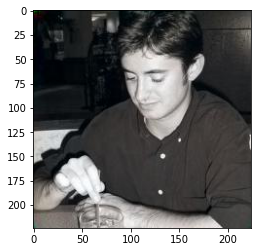

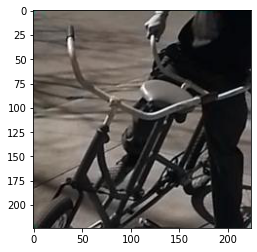

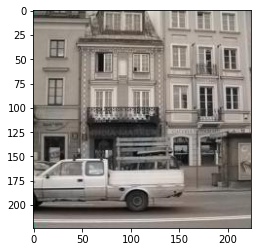

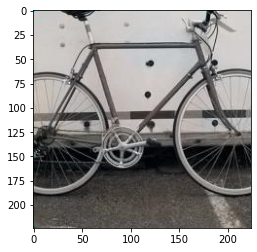

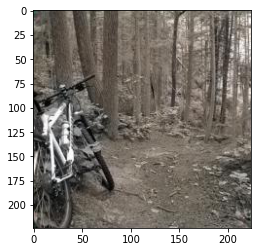

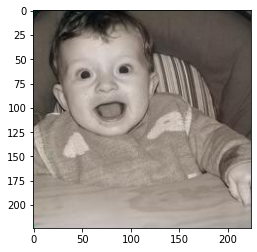

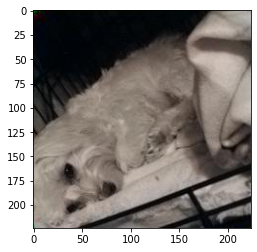

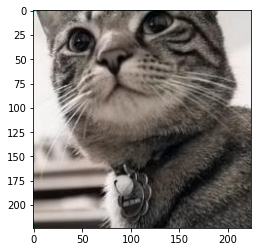

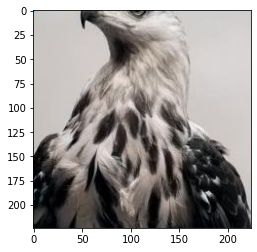

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Show results
imagesList = [1001, 1033, 1056, 1257, 1057, 1088, 1267, 115, 1225] #based on batch size of 32
for i in imagesList:
    image = mpimg.imread('/content/VOCdevkitOutputs/color/img-{}-epoch-19.jpg'.format(i))
    plt.figure()
    plt.imshow(image)
